In [ ]:
# Install required libraries

import requests
import json
import time
import datetime
from urllib.request import urlopen
import requests
import warnings
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns
import osmnx as ox
import networkx as nx
import geopandas as gpd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from pyproj import CRS
import os
import movingpandas as mpd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely import wkt

In [ ]:
# Read the CSV file into a DataFrame
jasper_gps = pd.read_csv('C:/Work/Wildfire/data_gps_sai/Jasper_export.csv')
jasper_gps.head()

,DateTime,registrationID,latitude,longitude,recordCount
0,2024-08-22 22:46:35,3a566868-9c2d-3caa-aabd-e798f485fe51,53.327960,-117.682840,1
1,2024-08-28 01:26:01,14784ab3-a28d-37f6-bc4f-7f733304c8ef,53.328080,-117.682980,1
2,2024-08-24 21:34:24,113beb6b-d214-3e86-9c43-057c5d02def7,53.328002,-117.682936,1
3,2024-08-24 21:34:24,3bb6e4af-03c0-3fa6-93df-e3984eb8a259,53.328003,-117.682940,1
4,2024-08-12 12:30:18,144293d1-1bb8-342a-95d7-76839b0fdacb,53.327995,-117.682890,1


In [ ]:
# Create a geometry column from latitude and longitude and create gdf for Jasper
geometry = [Point(xy) for xy in zip(jasper_gps['longitude'], jasper_gps['latitude'])]
jasper_gps = gpd.GeoDataFrame(jasper_gps, geometry=geometry)

jasper_gps.set_crs(epsg=4326, inplace=True)  # WGS 84
jasper_gps.head()

,DateTime,registrationID,latitude,longitude,recordCount,geometry
0,2024-08-22 22:46:35,3a566868-9c2d-3caa-aabd-e798f485fe51,53.327960,-117.682840,1,POINT (-117.68284 53.32796)
1,2024-08-28 01:26:01,14784ab3-a28d-37f6-bc4f-7f733304c8ef,53.328080,-117.682980,1,POINT (-117.68298 53.32808)
2,2024-08-24 21:34:24,113beb6b-d214-3e86-9c43-057c5d02def7,53.328002,-117.682936,1,POINT (-117.68294 53.32800)
3,2024-08-24 21:34:24,3bb6e4af-03c0-3fa6-93df-e3984eb8a259,53.328003,-117.682940,1,POINT (-117.68294 53.32800)
4,2024-08-12 12:30:18,144293d1-1bb8-342a-95d7-76839b0fdacb,53.327995,-117.682890,1,POINT (-117.68289 53.32800)


In [ ]:
# Calculate the start and end times
jasper_gps['DateTime'] = pd.to_datetime(jasper_gps['DateTime'])

start_time_j = jasper_gps['DateTime'].min()
end_time_j = jasper_gps['DateTime'].max()

print(f"Jasper data was collected from {start_time_j} to {end_time_j}.")

Jasper data was collected from 2024-07-14 00:00:00 to 2024-11-02 23:59:59.


In [ ]:
# Make new df within specified datetime
jasper_gps_14Jul_31Jul = jasper_gps[(jasper_gps['DateTime']>'2024-07-14') & (jasper_gps['DateTime']<'2024-08-01')]
jasper_gps_01Aug_14Aug = jasper_gps[(jasper_gps['DateTime']>'2024-08-01') & (jasper_gps['DateTime']<'2024-08-15')]
jasper_gps_15Aug_31Aug = jasper_gps[(jasper_gps['DateTime']>'2024-08-15') & (jasper_gps['DateTime']<'2024-09-01')]
jasper_gps_01Sep_14Sep = jasper_gps[(jasper_gps['DateTime']>'2024-09-01') & (jasper_gps['DateTime']<'2024-09-15')]


jasper_gps_14Jul_31Jul data was collected from 2024-07-14 00:00:01 to 2024-07-31 23:59:59.
jasper_gps_01Sep_14Sep data was collected from 2024-09-01 00:00:01 to 2024-09-14 23:59:59.
jasper_gps_15Oct_03Nov data was collected from 2024-10-15 00:00:01 to 2024-11-02 23:59:59.


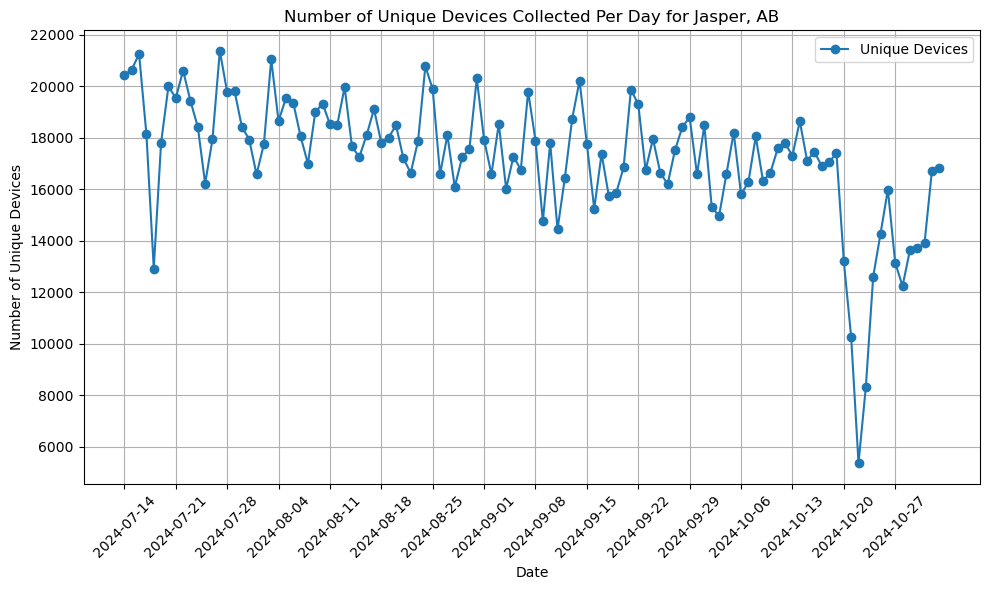

In [ ]:
# How many unique devices every day - Jasper

jasper_gps['Date'] = jasper_gps['DateTime'].dt.date
daily_unique_devices = (
    jasper_gps.groupby('Date')['registrationID']
    .nunique()
    .reset_index(name='UniqueDevices')
)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(daily_unique_devices['Date'], daily_unique_devices['UniqueDevices'], marker='o', label='Unique Devices')
plt.xticks(daily_unique_devices['Date'][::7], rotation=45)

plt.xlabel('Date')
plt.ylabel('Number of Unique Devices')
plt.title('Number of Unique Devices Collected Per Day for Jasper, AB')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

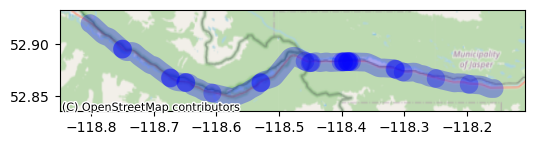

In [ ]:
# Importing highway shapefiles and visualizing it

jasper_yh16w_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/YH16_West_1kmBuffer.shp')
jasper_yh16w_shp.to_crs(epsg=4326, inplace=True)

jasper_yh16n_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/YH16_North_1kmBuffer.shp')
jasper_yh16n_shp.to_crs(epsg=4326, inplace=True)

# Jasper to Hinton
jasper_yh16ne_hinton_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/YH16_Northeast_Hinton_1kmBuffer.shp')
jasper_yh16ne_hinton_shp.to_crs(epsg=4326, inplace=True)

# Hinton to Edson
jasper_yh16ne_edson_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/YH16_Northeast_Edson_1kmBuffer.shp')
jasper_yh16ne_edson_shp.to_crs(epsg=4326, inplace=True)

jasper_icepark_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/IcePark_1kmBuffer.shp')
jasper_icepark_shp.to_crs(epsg=4326, inplace=True)

In [ ]:
# Perform Spatial Joins for Each Highway
jasper_gps_14Jul_31Jul_yh16w = gpd.sjoin(jasper_gps_14Jul_31Jul, jasper_yh16w_shp, how="inner", predicate="intersects")
jasper_gps_01Aug_14Aug_yh16w = gpd.sjoin(jasper_gps_01Aug_14Aug, jasper_yh16w_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_yh16w = gpd.sjoin(jasper_gps_15Aug_31Aug, jasper_yh16w_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_yh16w = gpd.sjoin(jasper_gps_01Sep_14Sep, jasper_yh16w_shp, how='inner', predicate='intersects')

jasper_gps_14Jul_31Jul_yh16n = gpd.sjoin(jasper_gps_14Jul_31Jul, jasper_yh16n_shp, how="inner", predicate="intersects")
jasper_gps_01Aug_14Aug_yh16n = gpd.sjoin(jasper_gps_01Aug_14Aug, jasper_yh16n_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_yh16n = gpd.sjoin(jasper_gps_15Aug_31Aug, jasper_yh16n_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_yh16n = gpd.sjoin(jasper_gps_01Sep_14Sep, jasper_yh16n_shp, how='inner', predicate='intersects')

jasper_gps_14Jul_31Jul_icepark = gpd.sjoin(jasper_gps_14Jul_31Jul, jasper_icepark_shp, how="inner", predicate="intersects")
jasper_gps_01Aug_14Aug_icepark = gpd.sjoin(jasper_gps_01Aug_14Aug, jasper_icepark_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_icepark = gpd.sjoin(jasper_gps_15Aug_31Aug, jasper_icepark_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_icepark = gpd.sjoin(jasper_gps_01Sep_14Sep, jasper_icepark_shp, how='inner', predicate='intersects')


In [ ]:
# Perform Spatial Joins for Each Highway
jasper_gps_14Jul_31Jul_yh16ne_hinton = gpd.sjoin(jasper_gps_14Jul_31Jul, jasper_yh16ne_hinton_shp, how="inner", predicate="intersects")
jasper_gps_01Aug_14Aug_yh16ne_hinton = gpd.sjoin(jasper_gps_01Aug_14Aug, jasper_yh16ne_hinton_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_yh16ne_hinton = gpd.sjoin(jasper_gps_15Aug_31Aug, jasper_yh16ne_hinton_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_yh16ne_hinton = gpd.sjoin(jasper_gps_01Sep_14Sep, jasper_yh16ne_hinton_shp, how='inner', predicate='intersects')

jasper_gps_14Jul_31Jul_yh16ne_edson = gpd.sjoin(jasper_gps_14Jul_31Jul, jasper_yh16ne_edson_shp, how="inner", predicate="intersects")
jasper_gps_01Aug_14Aug_yh16ne_edson = gpd.sjoin(jasper_gps_01Aug_14Aug, jasper_yh16ne_edson_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_yh16ne_edson = gpd.sjoin(jasper_gps_15Aug_31Aug, jasper_yh16ne_edson_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_yh16ne_edson = gpd.sjoin(jasper_gps_01Sep_14Sep, jasper_yh16ne_edson_shp, how='inner', predicate='intersects')


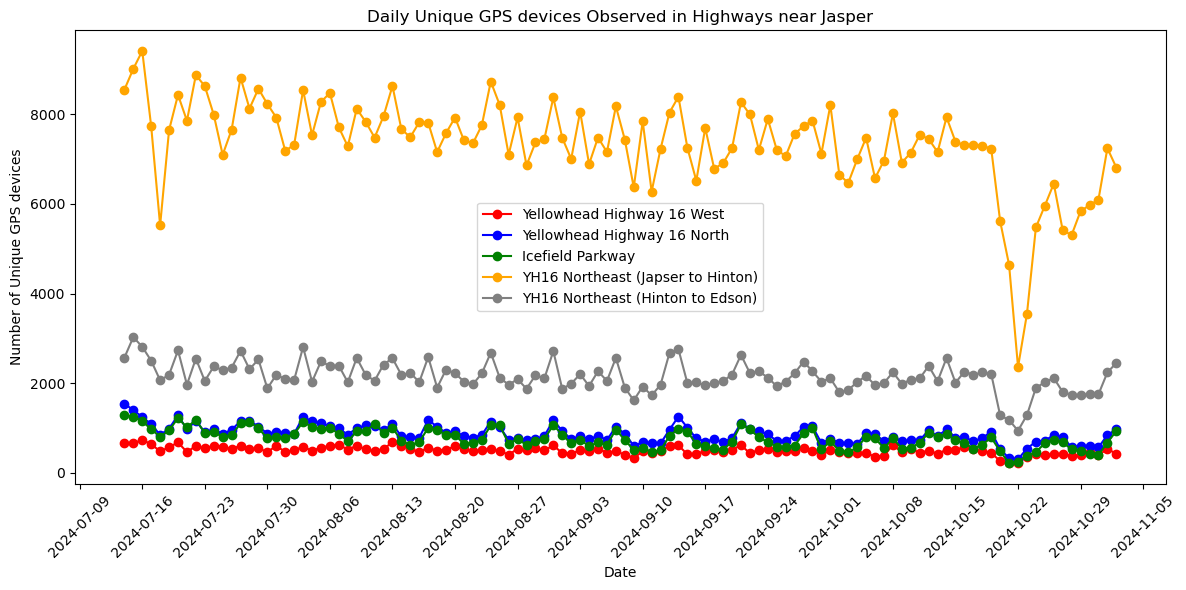

In [ ]:
# Function to calculate daily counts of unique devices for a given DataFrame
def calculate_daily_unique_devices(weekly_gps):
    weekly_gps['DateTime'] = pd.to_datetime(weekly_gps['DateTime'])
    daily_unique = weekly_gps.groupby(weekly_gps['DateTime'].dt.date)['registrationID'].nunique()
    return daily_unique

yh16w_weekly_unique_counts = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_yh16w,
    jasper_gps_01Aug_14Aug_yh16w,
    jasper_gps_15Aug_31Aug_yh16w,
    jasper_gps_01Sep_14Sep_yh16w
]:
    yh16w_weekly_unique_counts.append(calculate_daily_unique_devices(weekly_df))

yh16n_weekly_unique_counts = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_yh16n,
    jasper_gps_01Aug_14Aug_yh16n,
    jasper_gps_15Aug_31Aug_yh16n,
    jasper_gps_01Sep_14Sep_yh16n
]:
    yh16n_weekly_unique_counts.append(calculate_daily_unique_devices(weekly_df))

icepark_weekly_unique_counts = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_icepark,
    jasper_gps_01Aug_14Aug_icepark,
    jasper_gps_15Aug_31Aug_icepark,
    jasper_gps_01Sep_14Sep_icepark
]:
    icepark_weekly_unique_counts.append(calculate_daily_unique_devices(weekly_df))

yh16ne_hinton_weekly_unique_counts = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_yh16ne_hinton,
    jasper_gps_01Aug_14Aug_yh16ne_hinton,
    jasper_gps_15Aug_31Aug_yh16ne_hinton,
    jasper_gps_01Sep_14Sep_yh16ne_hinton
]:
    yh16ne_hinton_weekly_unique_counts.append(calculate_daily_unique_devices(weekly_df))

yh16ne_edson_weekly_unique_counts = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_yh16ne_edson,
    jasper_gps_01Aug_14Aug_yh16ne_edson,
    jasper_gps_15Aug_31Aug_yh16ne_edson,
    jasper_gps_01Sep_14Sep_yh16ne_edson
]:
    yh16ne_edson_weekly_unique_counts.append(calculate_daily_unique_devices(weekly_df))

yh16w_daily_unique_counts = pd.concat(yh16w_weekly_unique_counts).groupby(level=0).sum()
yh16n_daily_unique_counts = pd.concat(yh16n_weekly_unique_counts).groupby(level=0).sum()
icepark_daily_unique_counts = pd.concat(icepark_weekly_unique_counts).groupby(level=0).sum()
yh16ne_hinton_daily_unique_counts = pd.concat(yh16ne_hinton_weekly_unique_counts).groupby(level=0).sum()
yh16ne_edson_daily_unique_counts = pd.concat(yh16ne_edson_weekly_unique_counts).groupby(level=0).sum()

daily_unique_counts = pd.DataFrame({
    'YH16-W': yh16w_daily_unique_counts,
    'YH16-N': yh16n_daily_unique_counts,
    'ICEPARK': icepark_daily_unique_counts,
    'YH16NE-HINTON': yh16ne_hinton_daily_unique_counts,
    'YH16NE-EDSON': yh16ne_edson_daily_unique_counts
}).fillna(0)

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))
daily_unique_counts['YH16-W'].plot(ax=ax, label='Yellowhead Highway 16 West', color='red', marker='o')
daily_unique_counts['YH16-N'].plot(ax=ax, label='Yellowhead Highway 16 North', color='blue', marker='o')
daily_unique_counts['ICEPARK'].plot(ax=ax, label='Icefield Parkway', color='green', marker='o')
daily_unique_counts['YH16NE-HINTON'].plot(ax=ax, label='YH16 Northeast (Japser to Hinton)', color='orange', marker='o')
daily_unique_counts['YH16NE-EDSON'].plot(ax=ax, label='YH16 Northeast (Hinton to Edson)', color='grey', marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Unique GPS devices')
ax.set_title('Daily Unique GPS devices Observed in Highways near Jasper')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Read shapefile for towns

jasper_town_area_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/Jasper_Town_Area.shp')
jasper_town_area_shp.to_crs(epsg=4326, inplace=True)

hinton_town_area_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/Hinton_Town_Area.shp')
hinton_town_area_shp.to_crs(epsg=4326, inplace=True)

valem_town_area_shp = gpd.read_file('C:/Work/Wildfire/data_gps_sai/ab_gis/Valemount_Town_Area.shp')
valem_town_area_shp.to_crs(epsg=4326, inplace=True)

In [ ]:
# Spatial join for GPS entries
jasper_gps_14Jul_31Jul_jasper = gpd.sjoin(jasper_gps_14Jul_31Jul, jasper_town_area_shp, how='inner', predicate='intersects')
jasper_gps_01Aug_14Aug_jasper = gpd.sjoin(jasper_gps_01Aug_14Aug, jasper_town_area_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_jasper = gpd.sjoin(jasper_gps_15Aug_31Aug, jasper_town_area_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_jasper = gpd.sjoin(jasper_gps_01Sep_14Sep, jasper_town_area_shp, how='inner', predicate='intersects')

jasper_gps_14Jul_31Jul_hinton = gpd.sjoin(jasper_gps_14Jul_31Jul, hinton_town_area_shp, how='inner', predicate='intersects')
jasper_gps_01Aug_14Aug_hinton = gpd.sjoin(jasper_gps_01Aug_14Aug, hinton_town_area_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_hinton = gpd.sjoin(jasper_gps_15Aug_31Aug, hinton_town_area_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_hinton = gpd.sjoin(jasper_gps_01Sep_14Sep, hinton_town_area_shp, how='inner', predicate='intersects')

jasper_gps_14Jul_31Jul_valem = gpd.sjoin(jasper_gps_14Jul_31Jul, valem_town_area_shp, how='inner', predicate='intersects')
jasper_gps_01Aug_14Aug_valem = gpd.sjoin(jasper_gps_01Aug_14Aug, valem_town_area_shp, how='inner', predicate='intersects')
jasper_gps_15Aug_31Aug_valem = gpd.sjoin(jasper_gps_15Aug_31Aug, valem_town_area_shp, how='inner', predicate='intersects')
jasper_gps_01Sep_14Sep_valem = gpd.sjoin(jasper_gps_01Sep_14Sep, valem_town_area_shp, how='inner', predicate='intersects')

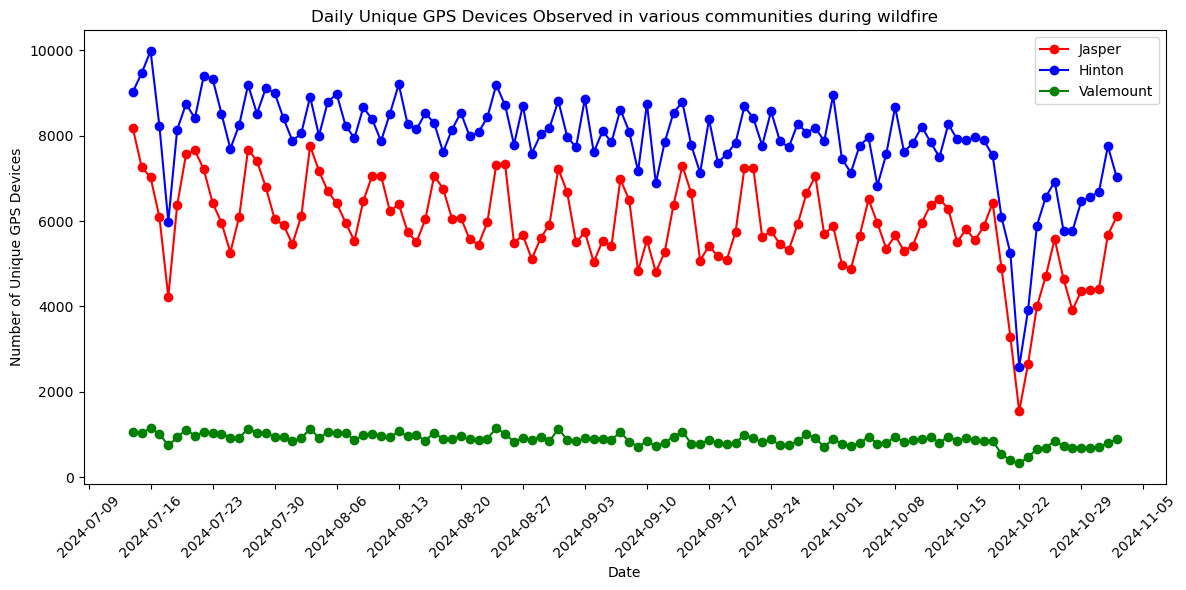

In [ ]:
# Calculating the number of unique GPS devices each day in each highway and visualizing the results
###################################################################################################

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to calculate daily counts of unique devices for a given DataFrame
def calculate_daily_unique_devices(weekly_gps):
    weekly_gps['DateTime'] = pd.to_datetime(weekly_gps['DateTime'])
    daily_unique = weekly_gps.groupby(weekly_gps['DateTime'].dt.date)['registrationID'].nunique()
    return daily_unique

# Process Jasper week-by-week for unique devices
jasper_weekly_unique_devices = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_jasper,
    jasper_gps_01Aug_14Aug_jasper,
    jasper_gps_15Aug_31Aug_jasper,
    jasper_gps_01Sep_14Sep_jasper
]:
    jasper_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

# Process Hinton week-by-week for unique devices
hinton_weekly_unique_devices = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_hinton,
    jasper_gps_01Aug_14Aug_hinton,
    jasper_gps_15Aug_31Aug_hinton,
    jasper_gps_01Sep_14Sep_hinton
]:
    hinton_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

# Process Valemount week-by-week for unique devices
valem_weekly_unique_devices = []
for weekly_df in [
    jasper_gps_14Jul_31Jul_valem,
    jasper_gps_01Aug_14Aug_valem,
    jasper_gps_15Aug_31Aug_valem,
    jasper_gps_01Sep_14Sep_valem
]:
    valem_weekly_unique_devices.append(calculate_daily_unique_devices(weekly_df))

# Combine weekly results into overall daily unique device counts
jasper_daily_unique_devices = pd.concat(jasper_weekly_unique_devices).groupby(level=0).sum()
hinton_daily_unique_devices = pd.concat(hinton_weekly_unique_devices).groupby(level=0).sum()
valem_daily_unique_devices = pd.concat(valem_weekly_unique_devices).groupby(level=0).sum()

# Create a DataFrame for plotting
daily_unique_devices = pd.DataFrame({
    'Jasper': jasper_daily_unique_devices,
    'Hinton': hinton_daily_unique_devices,
    'Valemount': valem_daily_unique_devices
}).fillna(0)

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all the data
daily_unique_devices['Jasper'].plot(ax=ax, label='Jasper', color='red', marker='o')
daily_unique_devices['Hinton'].plot(ax=ax, label='Hinton', color='blue', marker='o')
daily_unique_devices['Valemount'].plot(ax=ax, label='Valemount', color='green', marker='o')

# Customize the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

# Add labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Number of Unique GPS Devices')
ax.set_title('Daily Unique GPS Devices Observed in various communities during wildfire')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


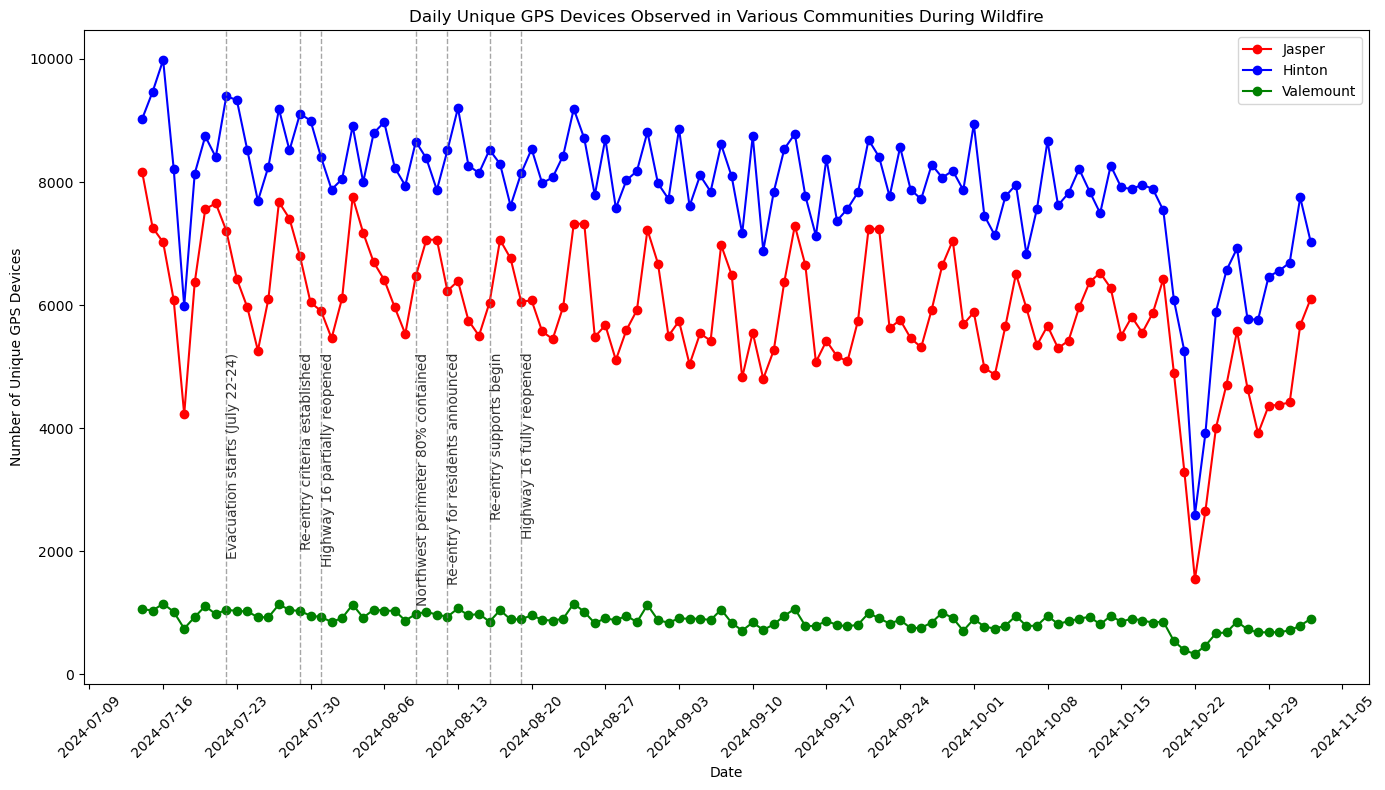

In [ ]:
# Key events with dates and descriptions
key_events = {
    '2024-07-22': 'Evacuation starts (July 22-24)',
    '2024-07-29': 'Re-entry criteria established',
    '2024-07-31': 'Highway 16 partially reopened',
    '2024-08-09': 'Northwest perimeter 80% contained',
    '2024-08-12': 'Re-entry for residents announced',
    '2024-08-16': 'Re-entry supports begin',
    '2024-08-19': 'Highway 16 fully reopened'
}

# Plot the graph
fig, ax = plt.subplots(figsize=(14, 8))

daily_unique_devices['Jasper'].plot(ax=ax, label='Jasper', color='red', marker='o')
daily_unique_devices['Hinton'].plot(ax=ax, label='Hinton', color='blue', marker='o')
daily_unique_devices['Valemount'].plot(ax=ax, label='Valemount', color='green', marker='o')

for date, event in key_events.items():
    ax.axvline(pd.to_datetime(date), color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax.text(
        pd.to_datetime(date),
        ax.get_ylim()[1] * 0.5,  # Position the text slightly below the top of the graph
        event,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        alpha=0.8
    )

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Unique GPS Devices')
ax.set_title('Daily Unique GPS Devices Observed in Various Communities During Wildfire')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
def add_approx_datetime(dataframe):
    dataframe['DateTime'] = pd.to_datetime(dataframe['DateTime'])  # Ensure DateTime is in datetime format
    dataframe['DateTimeApprox'] = dataframe['DateTime'].dt.round('4h')  # Round to the nearest 4-hour interval
    return dataframe

In [ ]:
jasper_gps_14Jul_31Jul_0 = add_approx_datetime(jasper_gps_14Jul_31Jul_0)
jasper_gps_01Aug_14Aug_0 = add_approx_datetime(jasper_gps_01Aug_14Aug_0)
jasper_gps_15Aug_31Aug_0 = add_approx_datetime(jasper_gps_15Aug_31Aug_0)
jasper_gps_01Sep_14Sep_0 = add_approx_datetime(jasper_gps_01Sep_14Sep_0)
jasper_gps_14Jul_31Jul_0.head()

,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,DateTimeApprox
4493746,2024-07-14 15:38:03,cfa55f6d-4761-3132-8ace-1f3b1d13ce1c,52.876210,-118.080960,2,POINT (-118.08096 52.87621),0,0,2024-07-14 16:00:00
4493747,2024-07-16 12:29:28,544a6f68-20ba-3d1f-a144-601dcc5ae432,52.876210,-118.080950,1,POINT (-118.08095 52.87621),0,0,2024-07-16 12:00:00
4493748,2024-07-16 12:29:28,aa976495-beb4-39d2-95ec-b87869b697d4,52.876208,-118.080948,1,POINT (-118.08095 52.87621),0,0,2024-07-16 12:00:00
4493749,2024-07-16 12:30:56,a9cb8e72-4071-3197-be7c-8b4f52408e2d,52.876200,-118.080950,1,POINT (-118.08095 52.87620),0,0,2024-07-16 12:00:00
4493750,2024-07-16 15:02:38,9796c8c7-5078-32eb-a8bd-48198be939c9,52.876210,-118.080930,4,POINT (-118.08093 52.87621),0,0,2024-07-16 16:00:00


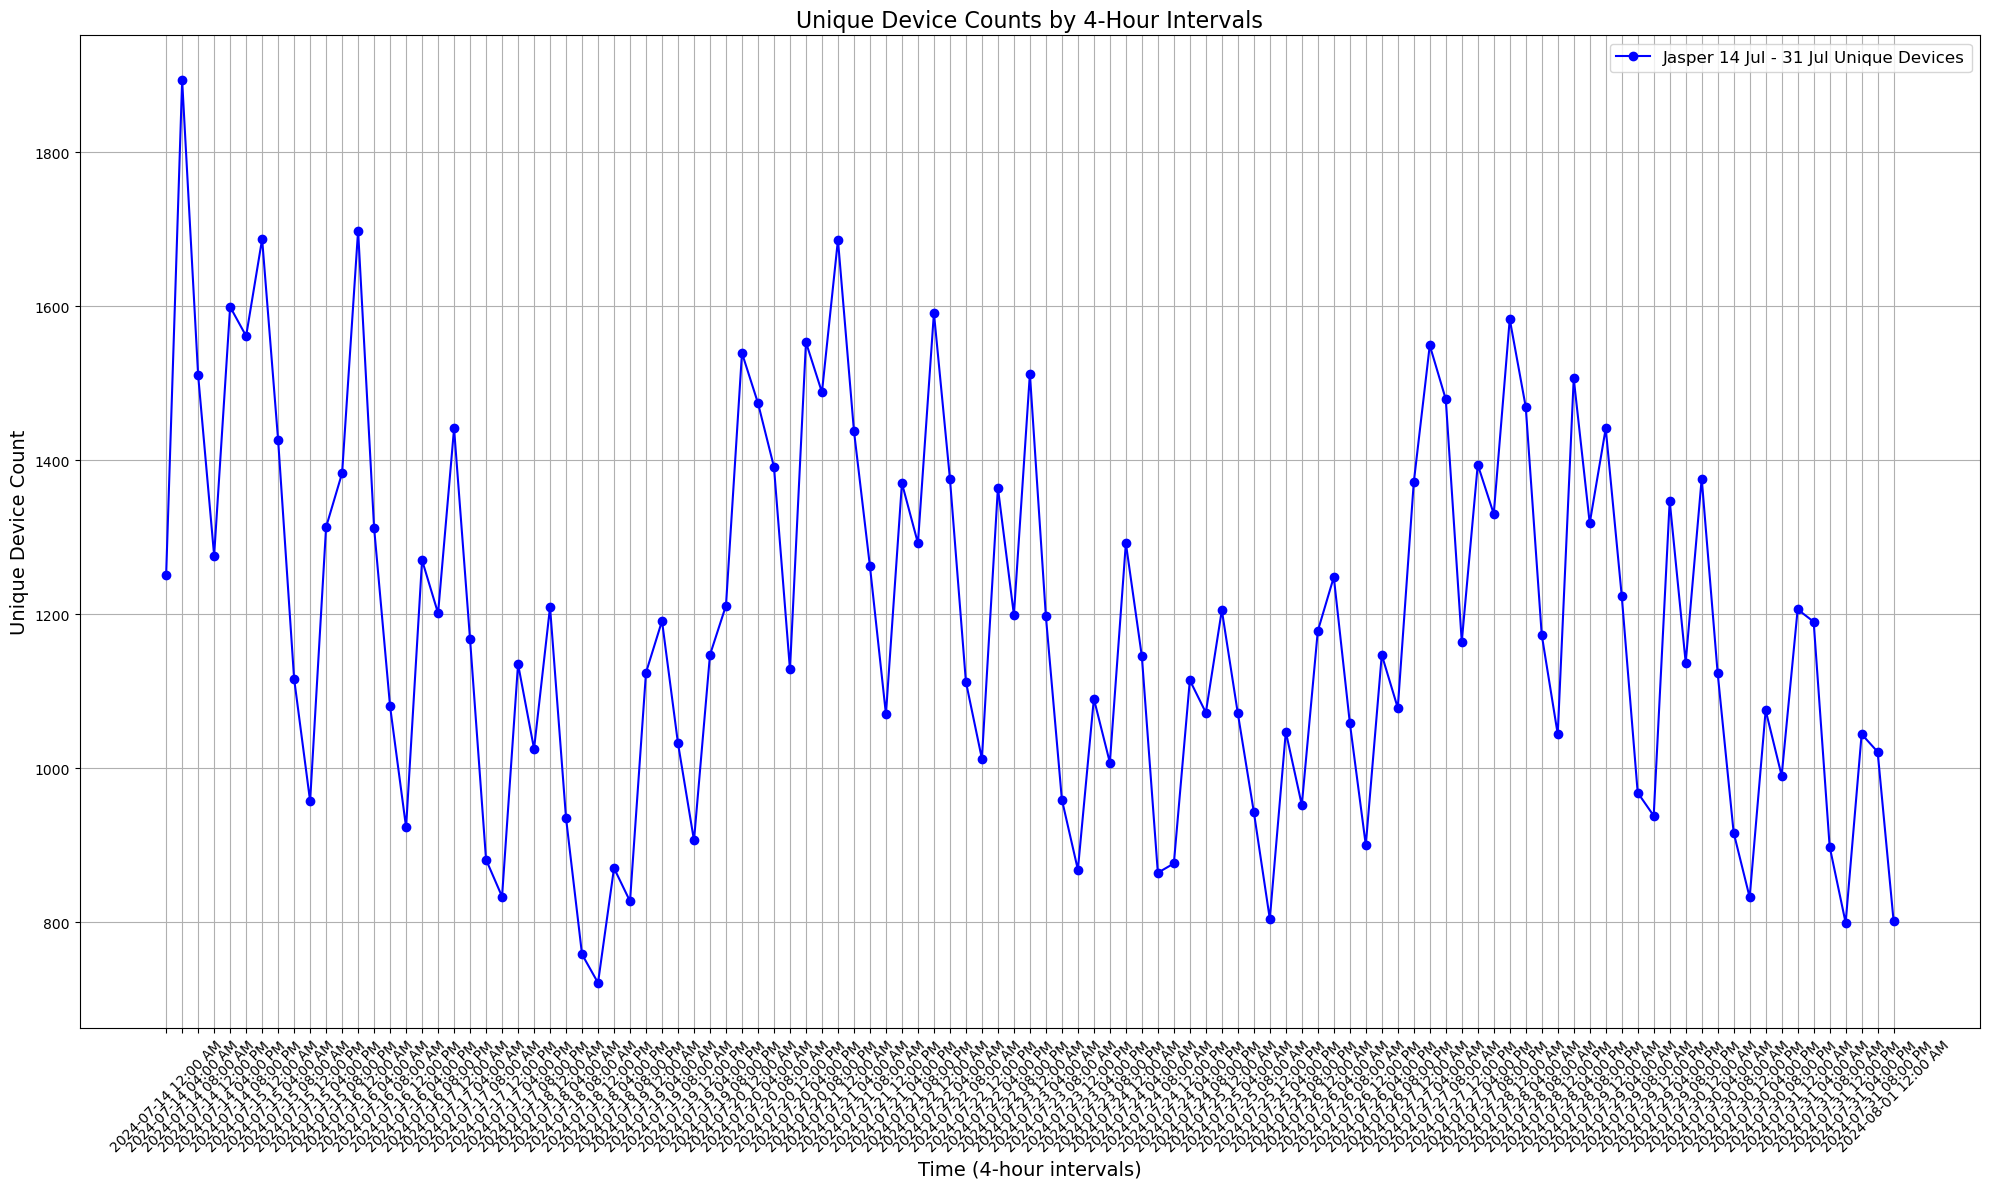

In [ ]:
# Compute unique counts for each dataframe
jasper_gps_14Jul_31Jul_0_unique_counts = jasper_gps_14Jul_31Jul_0.groupby('DateTimeApprox')['registrationID'].nunique()

# Create the plot
plt.figure(figsize=(20, 12))

plt.plot(
    jasper_gps_14Jul_31Jul_0_unique_counts.index,
    jasper_gps_14Jul_31Jul_0_unique_counts.values,
    label='Jasper 14 Jul - 31 Jul Unique Devices',
    color='blue',
    marker='o'
)

plt.title("Unique Device Counts by 4-Hour Intervals", fontsize=16)
plt.xlabel('Time (4-hour intervals)', fontsize=14)
plt.ylabel('Unique Device Count', fontsize=14)
plt.xticks(
    jasper_gps_14Jul_31Jul_0_unique_counts.index,
    jasper_gps_14Jul_31Jul_0_unique_counts.index.strftime('%Y-%m-%d %I:%M %p'),
    rotation=45,
    fontsize=10
)

plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
